# Collaborative Filtering Model

### 1. Introduction

This notebook is the second part of a Master Thesis project on Music Recommender Systems at Universitat Pompeu Fabra. Building on the work from the first notebook, where we processed and prepared the final dataset, this section focuses on implementing a collaborative filtering (CF) model aimed at improving recommendation diversity.

The primary objective of this phase is to explore and optimize metrics that are often overlooked in traditional accuracy-driven recommender systems, specifically Aggregate Diversity (Agg-Div), Long-Tail Coverage (LC), and User Popularity Deviation (UPD).

By enhancing these aspects, we aim to improve the diversity of recommendations, helping users discover a broader range of music and providing lesser-known artists with better opportunities to be heard. This exploration will involve refining a standard CF model to better serve both user preferences and artist visibility within the recommendation ecosystem.

### 2. Importing and Preparing the Dataset

Import the dataset that was built and processed in the first notebook. After importing, we will normalize the data for building and evaluating the collaborative filtering model.

In [4]:
# Import necessary libraries
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

# Access dataset csv from Google Drive
path = '/content/drive/My Drive/SMC_Thesis/final_dataframe.csv'
data = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Observe that the dataset is correctly imported
data.head()

,userID,artistID,name,weight,tagID,tagValue,day,month,year,friendID,id
0,2,52,Morcheeba,11690.0,13,chillout,1,4,2009,"[275, 428, 515, 761, 831, 909, 1209, 1210, 123...",52.0
1,2,52,Morcheeba,11690.0,15,downtempo,1,4,2009,"[275, 428, 515, 761, 831, 909, 1209, 1210, 123...",52.0
2,2,52,Morcheeba,11690.0,18,electronic,1,4,2009,"[275, 428, 515, 761, 831, 909, 1209, 1210, 123...",52.0
3,2,52,Morcheeba,11690.0,21,trip-hop,1,4,2009,"[275, 428, 515, 761, 831, 909, 1209, 1210, 123...",52.0
4,2,52,Morcheeba,11690.0,41,female vovalists,1,4,2009,"[275, 428, 515, 761, 831, 909, 1209, 1210, 123...",52.0


In [7]:
len(data)

186479

In [8]:
# Normalize 'weight' column using min-max normalization
min_weight = data['weight'].min()
max_weight = data['weight'].max()
data['normalized_weight'] = (data['weight'] - min_weight) / (max_weight - min_weight)

### 3. Exploratory Data Analysis

We will conduct an exploratory data analysis to gain insights into the key characteristics of the dataset. We will examine various parameters, including user-artist interactions, the distribution of interactions per user and per artist and the most and least common tags. This analysis will help us understand the underlying structure of the data.

**User and Artist Interaction**

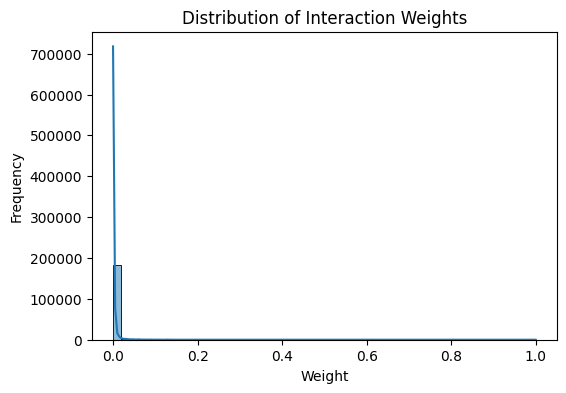

In [ ]:
# Distribution of interactions (weights)
plt.figure(figsize=(6, 4))
sns.histplot(data['normalized_weight'], bins=50, kde=True)
plt.title('Distribution of Interaction Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

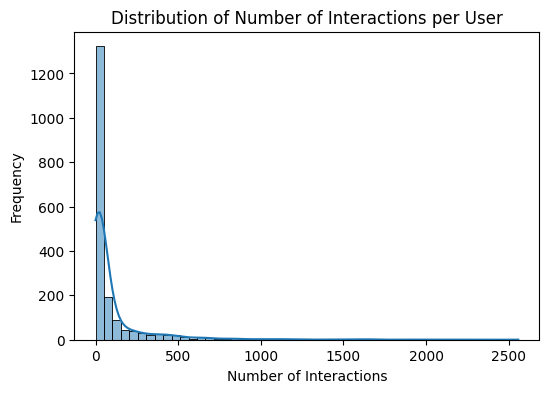

In [ ]:
# Number of interactions per user
user_interactions = data.groupby('userID')['name'].count()
plt.figure(figsize=(6, 4))
sns.histplot(user_interactions, bins=50, kde=True)
plt.title('Distribution of Number of Interactions per User')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.show()

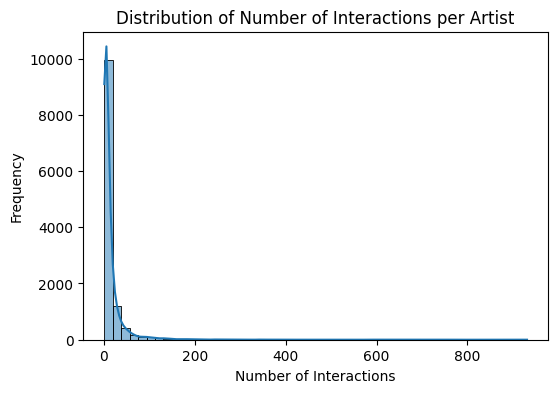

In [ ]:
# Number of interactions per artist
artist_interactions = data.groupby('name')['userID'].count()
plt.figure(figsize=(6, 4))
sns.histplot(artist_interactions, bins=50, kde=True)
plt.title('Distribution of Number of Interactions per Artist')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.show()

**Tag Analysis**

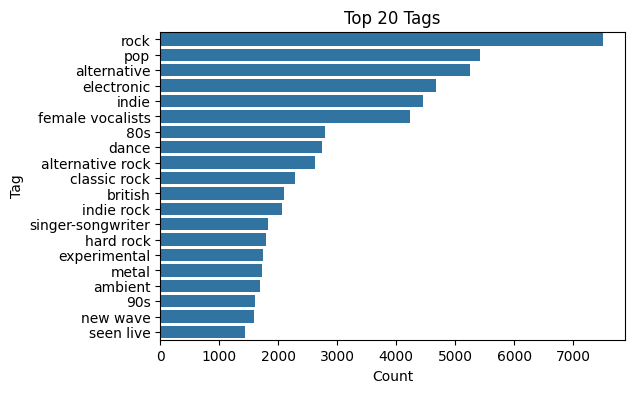

In [ ]:
# Most common tags
tag_counts = data['tagValue'].value_counts().head(20)
plt.figure(figsize=(6, 4))
sns.barplot(x=tag_counts.values, y=tag_counts.index)
plt.title('Top 20 Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

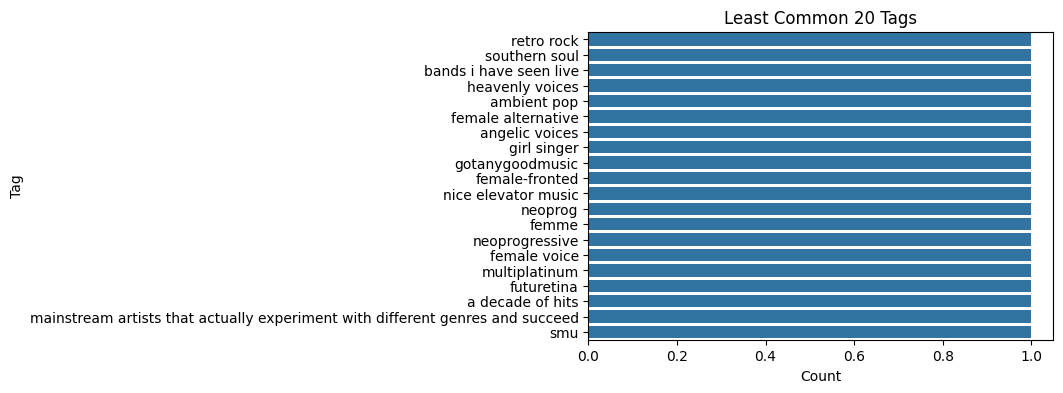

In [ ]:
# Least common tags
least_common_tags = data['tagValue'].value_counts().tail(20)
plt.figure(figsize=(6, 4))
sns.barplot(x=least_common_tags.values, y=least_common_tags.index)
plt.title('Least Common 20 Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

### 4. Collaborative Filtering Model

In this section, we will begin constructing the Collaborative Filtering model using matrix factorization techniques, specifically Singular Value Decomposition (SVD), to recommend artists to users based on their interaction and listening history. Additionally, we will incorporate social influence into the model, recognizing that social relationships can significantly impact music preferences and, consequently, the recommendations generated.

**Matrix Factorization using SVD**

In [9]:
# Aggregate the weights by summing them for duplicate (userID, artist name) pairs
aggregated_data = data.groupby(['userID', 'name']).agg({'normalized_weight': 'sum'}).reset_index()

# Create the interaction matrix
interaction_matrix = aggregated_data.pivot(index='userID', columns='name', values='normalized_weight').fillna(0)

# Create the user_id_mapping
#  (used later on as the matrix reindexes the users from 0 instead of following the original index)
user_id_mapping = {index: user_id for index, user_id in enumerate(interaction_matrix.index)}

# Normalize by subtracting mean user rating
user_ratings_mean = np.mean(interaction_matrix, axis=1)
interaction_matrix_norm = interaction_matrix - user_ratings_mean.values.reshape(-1, 1)

# Convert the interaction matrix to a sparse matrix
interaction_matrix_sparse = csr_matrix(interaction_matrix_norm.values)

# Function to calculate RMSE
def rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

# A higher k means more latent features are considered, that will provide better recommendations
k = 100
U, sigma, Vt = svds(interaction_matrix_sparse, k=k)
sigma = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.values.reshape(-1, 1)

print(f"RMSE with k={k}: ", rmse(predicted_ratings, interaction_matrix.values))

# Store the predicted ratings
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=interaction_matrix.columns)

RMSE with k=100:  0.015165057648886569


In [10]:
# Overview of the mapping
print("First few mappings:")
for i, user_id in list(user_id_mapping.items())[:10]:
    print(f"Original userID {user_id} maps to index {i}")

First few mappings:
Original userID 2 maps to index 0
Original userID 3 maps to index 1
Original userID 4 maps to index 2
Original userID 5 maps to index 3
Original userID 6 maps to index 4
Original userID 7 maps to index 5
Original userID 8 maps to index 6
Original userID 9 maps to index 7
Original userID 10 maps to index 8
Original userID 11 maps to index 9


**Incorporating Social Influence**



In [11]:
# Function to calculate the influence of friends on the user's preferences
def get_friend_influence(user_id, interaction_matrix):
    # Retrieve the list of friends for the user
    friends = data.loc[data['userID'] == user_id, 'friendID'].values[0]
    # Filter out friends who are not in the interaction_matrix index
    valid_friends = [friend for friend in friends if friend in interaction_matrix.index]

    if len(valid_friends) == 0:
      # Return zeros if no valid friends
      return np.zeros(interaction_matrix.shape[1])

    # Aggregate valid friends interactions
    friends_interactions = interaction_matrix.loc[valid_friends].mean(axis=0)
    return friends_interactions

# Function to apply the social influence to the interaction matrix
def apply_social_influence(interaction_matrix):
    social_matrix = interaction_matrix.copy()
    for user_id in interaction_matrix.index:
        # Use the original 'userID' directly, no need to map back from an index
        if user_id not in user_id_mapping.values():
            print(f"Warning: User ID {user_id} not found in user_id_mapping. Skipping.")
            continue

        social_influence = get_friend_influence(user_id, interaction_matrix)
        # Incorporate social influence
        social_matrix.loc[user_id] += social_influence
    return social_matrix

# Apply social influence
interaction_matrix_with_social = apply_social_influence(interaction_matrix_norm)
# Store the new predicted ratings with social influence
predicted_ratings_with_social_df = pd.DataFrame(interaction_matrix_with_social, columns=interaction_matrix.columns)

In [12]:
interaction_matrix_sparse = csr_matrix(interaction_matrix_with_social.values)
U, sigma, Vt = svds(interaction_matrix_sparse, k=k)
sigma = np.diag(sigma)

# Predict ratings with social influence
predicted_ratings_with_social = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.values.reshape(-1, 1)
predicted_ratings_with_social_df = pd.DataFrame(predicted_ratings_with_social, columns=interaction_matrix.columns)
print("RMSE with Social Influence: ", rmse(predicted_ratings_with_social, interaction_matrix.values))

RMSE with Social Influence:  0.015165057648885915


## 5. Computing metrics



In this section, we will generate the top 5 recommendations for all users to evaluate the model using our chosen metrics. Additionally, we will create a dictionary that captures all user interactions, tracking the popularity of each artist by counting the number of times a user has listened to them. This will allow us to assess how popular an artist is when they are recommended.

The metrics we will use to evaluate our model are:

*   **Aggregate Diversity** (Agg-Div): This metric measures the ratio of unique recommended items compared to all available items in the catalog. It helps us understand how diverse the recommendations are across the entire user base.

*   **Long-tail Coverage** (LC): The percentage of long-tail items that are covered by the recommender system. It ensures that the system is not just recommending the most popular items but also those from the long tail of the distribution.

*   **User Popularity Deviation** (UPD): Measures the average amount of deviation the algorithms impose on users in different groups compared to what their original interest in popularity was.

The formulas of these metrics can be checked in the Master Thesis Report.

The formulas for these metrics can be found in the Master Thesis Report. Including these metrics in our evaluation will help us determine if the recommender system is promoting diversity, recommending items from the long tail, and whether it aligns with or deviates from users' original tastes.

In [13]:
# Generate top 5 recommendations for the users
def get_top_n_recommendations(predicted_ratings_df, user_id_mapping, n=5):
    recommendations = {}
    for user_index in predicted_ratings_df.index:
        # Map back to the original userID
        original_user_id = user_id_mapping[user_index]
        top_n_items = predicted_ratings_df.loc[user_index].sort_values(ascending=False).head(n).index.tolist()
        # Store recommendations using the original userID
        recommendations[original_user_id] = top_n_items
    return recommendations

recommendations = get_top_n_recommendations(predicted_ratings_with_social_df, user_id_mapping, n=5)

In [14]:
# Function to get user interactions as a dictionary
def get_user_interactions(data):
    user_interactions = {}
    for user in data['userID'].unique():
        # Get the artist names the user has interacted with and their popularity
        interacted_artists = data[data['userID'] == user]['name']
        artist_popularity = interacted_artists.map(data['name'].value_counts())
        user_interactions[user] = artist_popularity
    return user_interactions

user_interactions = get_user_interactions(data)

**Measuring Aggregate Diversity (Agg-Div):**

In [15]:
def calculate_agg_div(recommendations, all_items):
    # Flatten the list of recommendations across all users
    unique_recommended_items = set([item for sublist in recommendations.values() for item in sublist])
    # Aggregate diversity is the ratio of unique recommended items to all available items
    agg_div = len(unique_recommended_items) / len(all_items)
    return agg_div

all_items = set(data['name'].unique())  # Set of all available artist names in the dataset
agg_div_score = calculate_agg_div(recommendations, all_items)
print(f"Aggregate Diversity (Agg-Div): {agg_div_score}")

Aggregate Diversity (Agg-Div): 0.031729025877699026


**Measuring Long-tail Coverage (LC):**

In [16]:
def calculate_long_tail_coverage(recommendations, long_tail_items):
    # Flatten the list of recommendations across all users
    recommended_long_tail_items = set([item for sublist in recommendations.values() for item in sublist if item in long_tail_items])
    # Long-tail coverage is the ratio of recommended long-tail items to all long-tail items
    long_tail_coverage = len(recommended_long_tail_items) / len(long_tail_items)
    return long_tail_coverage

# We will assume the bottom 30% in popularity are long-tail
popularity_threshold = data['artistID'].value_counts().quantile(0.3)
long_tail_items = set(data[data['artistID'].map(data['artistID'].value_counts()) <= popularity_threshold]['name'].unique())
lc_score = calculate_long_tail_coverage(recommendations, long_tail_items)
print(f"Long-tail Coverage (LC): {lc_score}")

Long-tail Coverage (LC): 0.0012496875781054736


**Measuring User Popularity Deviation (UPD):**

In [17]:
def calculate_upd(recommendations, user_interactions):
    total_upd = 0
    num_users = len(recommendations)
    # Calculate the popularity score for each artist by counting how many times
    #   each artist appears in the dataset (how many times they have been listened to)
    artist_popularity = data['name'].value_counts()

    # Iterate over each user and their recommended artists
    for user, recs in recommendations.items():
        # Calculate the average popularity of the artists the user originally interacted with
        original_popularity = user_interactions[user].mean()
        # Calculate the average popularity of the recommended artists
        rec_popularity = artist_popularity[recs].mean()
        total_upd += abs(original_popularity - rec_popularity)

    return total_upd / num_users

upd_score = calculate_upd(recommendations, user_interactions)
print(f"User Popularity Deviation (UPD): {upd_score}")

User Popularity Deviation (UPD): 130.42179465700445


Given the high UPD and relatively low scores for the other metrics, we need to investigate whether the model is recommending either very popular or extremely niche items to users. This behavior might indicate that the recommendations are diverging significantly from what users typically listen to or expect, potentially affecting the overall user experience.

In [18]:
def calculate_popularity_distributions(recommendations, user_interactions, data):
    original_popularity = []
    recommended_popularity = []
    for user, recs in recommendations.items():
        # Original popularity (how many times each artist appears in the user's interaction history)
        user_original_popularity = user_interactions[user].map(user_interactions[user].value_counts())
        original_popularity.extend(user_original_popularity.values)
        # Recommended popularity (how popular each recommended artist is across all users)
        rec_popularity = data[data['name'].isin(recs)]['name'].map(data['name'].value_counts())
        recommended_popularity.extend(rec_popularity.values)

    return original_popularity, recommended_popularity

original_popularity, recommended_popularity = calculate_popularity_distributions(recommendations, user_interactions, data)

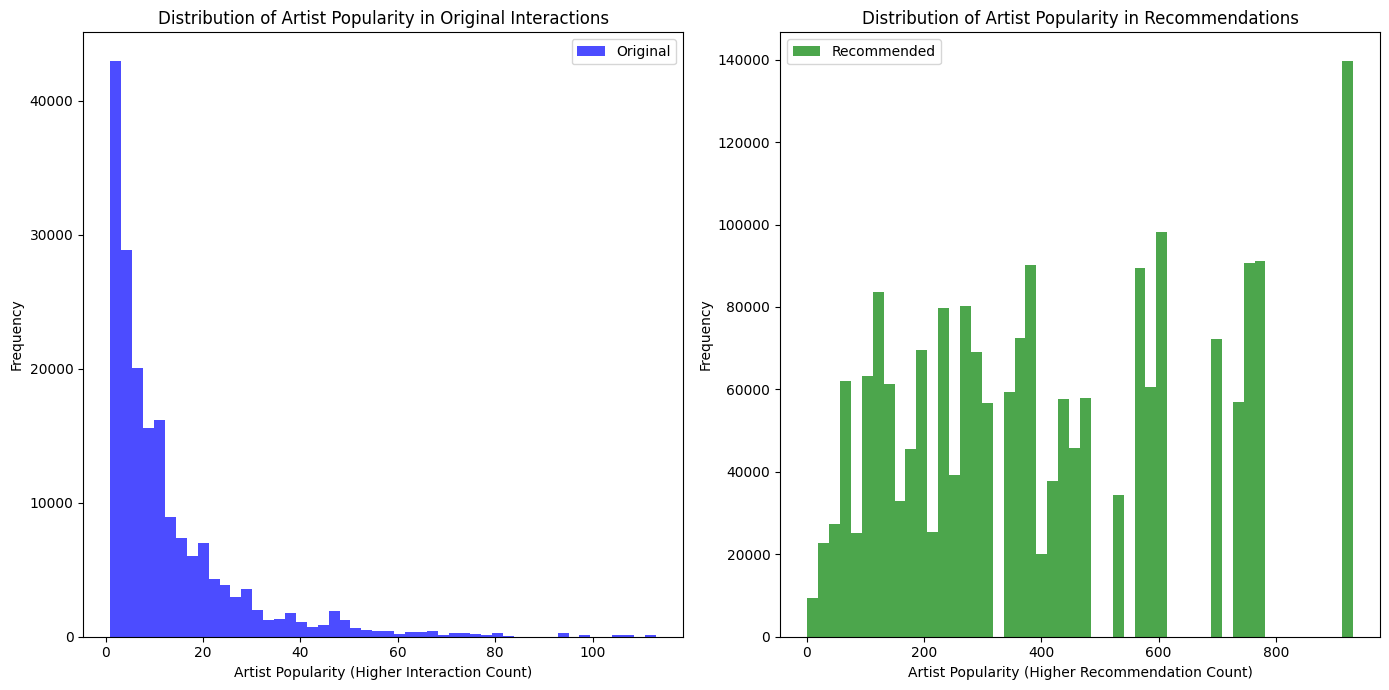

In [22]:
plt.figure(figsize=(14, 7))

# Histogram for original popularity
plt.subplot(1, 2, 1)
plt.hist(original_popularity, bins=50, alpha=0.7, color='blue', label='Original')
plt.title("Distribution of Artist Popularity in Original Interactions")
plt.xlabel("Artist Popularity (Higher Interaction Count)")
plt.ylabel("Frequency")
plt.legend()

# Histogram for recommended popularity
plt.subplot(1, 2, 2)
plt.hist(recommended_popularity, bins=50, alpha=0.7, color='green', label='Recommended')
plt.title("Distribution of Artist Popularity in Recommendations")
plt.xlabel("Artist Popularity (Higher Recommendation Count)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# Count the number of interactions per artist
artist_popularity = data['name'].value_counts()
# Display the top 5 most popular artists
print("Most Popular Artists:")
print(artist_popularity.head())

Most Popular Artists:
name
Britney Spears        931
Lady Gaga             767
Christina Aguilera    762
Madonna               730
Depeche Mode          701
Name: count, dtype: int64


In [21]:
# Sort the artists by popularity in ascending order
least_popular_artists = artist_popularity.sort_values(ascending=True)
# Display the least popular artists
print("Least Popular Artists:")
print(least_popular_artists.head(5))

Least Popular Artists:
name
Vilkduja             1
Michael Tsukerman    1
The Blizzard         1
ミドリ                  1
Lebo M               1
Name: count, dtype: int64


### 6. Optimizing the CF Model



In this final section, we will focus on optimizing the Collaborative Filtering (CF) model. Our initial model and metric evaluations revealed that the computed recommendations lacked diversity and did not sufficiently promote artists in the long tail of the popularity distribution. Now, we will refine the model to address these issues, aiming to produce more diverse recommendations that enhance the discovery experience for users and increase visibility for lesser-known artists.

**Part 1: Improving Matrix Factorization using SVD**

In this section, we will enhance the matrix factorization by increasing the number of latent factors, which means raising the k value in our SVD computation. By increasing k, the model can capture more underlying patterns in the data, as additional factors may be required to reflect the diversity in user behavior and item characteristics. This adjustment is expected to lead to better and more diverse recommendations.

In [23]:
# Aggregate the weights by summing them for duplicate (userID, artistID) pairs
aggregated_data = data.groupby(['userID', 'name']).agg({'normalized_weight': 'sum'}).reset_index()

# Create the interaction matrix
interaction_matrix = aggregated_data.pivot(index='userID', columns='name', values='normalized_weight').fillna(0)

# Create the user_id_mapping
user_id_mapping = {index: user_id for index, user_id in enumerate(interaction_matrix.index)}

# Normalize by subtracting mean user rating
user_ratings_mean = np.mean(interaction_matrix, axis=1)
interaction_matrix_norm = interaction_matrix - user_ratings_mean.values.reshape(-1, 1)

# Convert the interaction matrix to a sparse matrix
interaction_matrix_sparse = csr_matrix(interaction_matrix_norm.values)

# Increase k value for better recommendations
k = 700
U, sigma, Vt = svds(interaction_matrix_sparse, k=k)
sigma = np.diag(sigma)

predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.values.reshape(-1, 1)
print(f"RMSE with k={k}: ", rmse(predicted_ratings, interaction_matrix.values))

# Store the predicted ratings
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=interaction_matrix.columns)

RMSE with k=700:  0.00105922253907498


**Part 2: Incorporating Social Influence with Weighting**

The first step to improve the model is to adjust the social influence factors by incorporating a weight in the social influence parameter, to control the influence of friends' preferences versus the user's original preferences.
So, if it is the case that more popular items are being recommended to the user because their friends listen to popular music, it will take more into account the original users preferences.

In [24]:
# Weighting factor for social influence
beta = 0.5  # Adjust this parameter to tune the influence of social factors

# Modified 'apply_social_influence' to apply the social influence to the interaction matrix
def apply_social_influence(interaction_matrix):
    social_matrix = interaction_matrix.copy()
    for user_id in interaction_matrix.index:
        # Use the original userID directly, no need to map back from an index
        if user_id not in user_id_mapping.values():
            print(f"Warning: User ID {user_id} not found in user_id_mapping. Skipping.")
            continue

        social_influence = get_friend_influence(user_id, interaction_matrix)
        # Incorporate social influence with weighting
        social_matrix.loc[user_id] = (1 - beta) * social_matrix.loc[user_id] + beta * social_influence

    return social_matrix

# Apply social influence
interaction_matrix_with_social = apply_social_influence(interaction_matrix_norm)

# Store the new predicted ratings with social influence
predicted_ratings_with_social_df = pd.DataFrame(interaction_matrix_with_social, columns=interaction_matrix.columns)

# Convert the modified interaction matrix to a sparse matrix
interaction_matrix_sparse = csr_matrix(interaction_matrix_with_social.values)

# Apply SVD
U, sigma, Vt = svds(interaction_matrix_sparse, k=k)
sigma = np.diag(sigma)

# Predict ratings with social influence
predicted_ratings_with_social = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.values.reshape(-1, 1)
predicted_ratings_with_social_df = pd.DataFrame(predicted_ratings_with_social, columns=interaction_matrix.columns)
print("RMSE with Social Influence: ", rmse(predicted_ratings_with_social, interaction_matrix_with_social.values))

RMSE with Social Influence:  9.100932265993587e-05


**Part 3: Diversified Ranking and Long-tail Promotion**

In order to diversify the model and boost a little the long-tail items, we are including a thrid part to the model.
A Diversification ranking, which after providing the top-15 recommendations for the users, it will apply algorithms like Maximal Marginal Relevance (MMR) to reorder the list to balance relevance with diversity.
Furthemore, we will also incorporate an algorithm for Long-Tail promotion, to increase the chances of long-tail items being recommended by slightly boosting their scores.

In [25]:
# Function to generate recommendations with long-tail promotion and diversified ranking
def get_diversified_recommendations(user_id, predicted_ratings_df, long_tail_items, similarity_matrix, n=15, diversity_factor=0.85, long_tail_boost=1.8):
    top_n_items = predicted_ratings_df.loc[user_id].sort_values(ascending=False).head(n).index.tolist()
    for i, item in enumerate(top_n_items):
        if item in long_tail_items:
            predicted_ratings_df.loc[user_id, item] *= long_tail_boost

    top_n_items = predicted_ratings_df.loc[user_id].sort_values(ascending=False).head(n).index.tolist()
    final_ranking = []
    candidate_items = list(top_n_items)
    while candidate_items:
        item = candidate_items.pop(0)
        final_ranking.append(item)
        if candidate_items:
            candidate_items.sort(key=lambda x: (1 - diversity_factor) * predicted_ratings_df.loc[user_id, x]
                                 - diversity_factor * max([similarity_matrix.loc[item, y] for y in final_ranking]), reverse=True)

    return final_ranking

# Ensure similarity matrix uses column 'name' as the index and columns
similarity_matrix = pd.DataFrame(cosine_similarity(predicted_ratings_with_social_df.T, predicted_ratings_with_social_df.T),
                                 index=predicted_ratings_with_social_df.columns,
                                 columns=predicted_ratings_with_social_df.columns)

# Identify long-tail items using 'name' (bottom 20% in popularity)
popularity_threshold = data['name'].value_counts().quantile(0.2)
long_tail_items = set(data[data['name'].map(data['name'].value_counts()) <= popularity_threshold]['name'].unique())

# Generate recommendations for all users using original `userID`
all_recommendations = {}
for user_index in predicted_ratings_with_social_df.index:
    original_user_id = user_id_mapping[user_index]
    all_recommendations[original_user_id] = get_diversified_recommendations(user_index, predicted_ratings_with_social_df, long_tail_items, similarity_matrix, n=15)

print("Generated recommendations for all users.")

Generated recommendations for all users.


We proceed to compute the same metrics as done before for the new recommendations:

In [26]:
# We can use the same 'user_interactions' dictionary as the data comes fromt the dataset directly and not the model
agg_div_score = calculate_agg_div(all_recommendations, all_items)
print(f"Aggregate Diversity (Agg-Div): {agg_div_score}")

Aggregate Diversity (Agg-Div): 0.2971814735454096


In [27]:
lc_score = calculate_long_tail_coverage(all_recommendations, long_tail_items)
print(f"Long-tail Coverage (LC): {lc_score}")

Long-tail Coverage (LC): 0.0768435561681599


In [28]:
upd_score = calculate_upd(all_recommendations, user_interactions)
print(f"User Popularity Deviation (UPD): {upd_score}")

User Popularity Deviation (UPD): 74.77796712002626


In [29]:
# Calculate the distributions
original_popularity, recommended_popularity = calculate_popularity_distributions(all_recommendations, user_interactions, data)

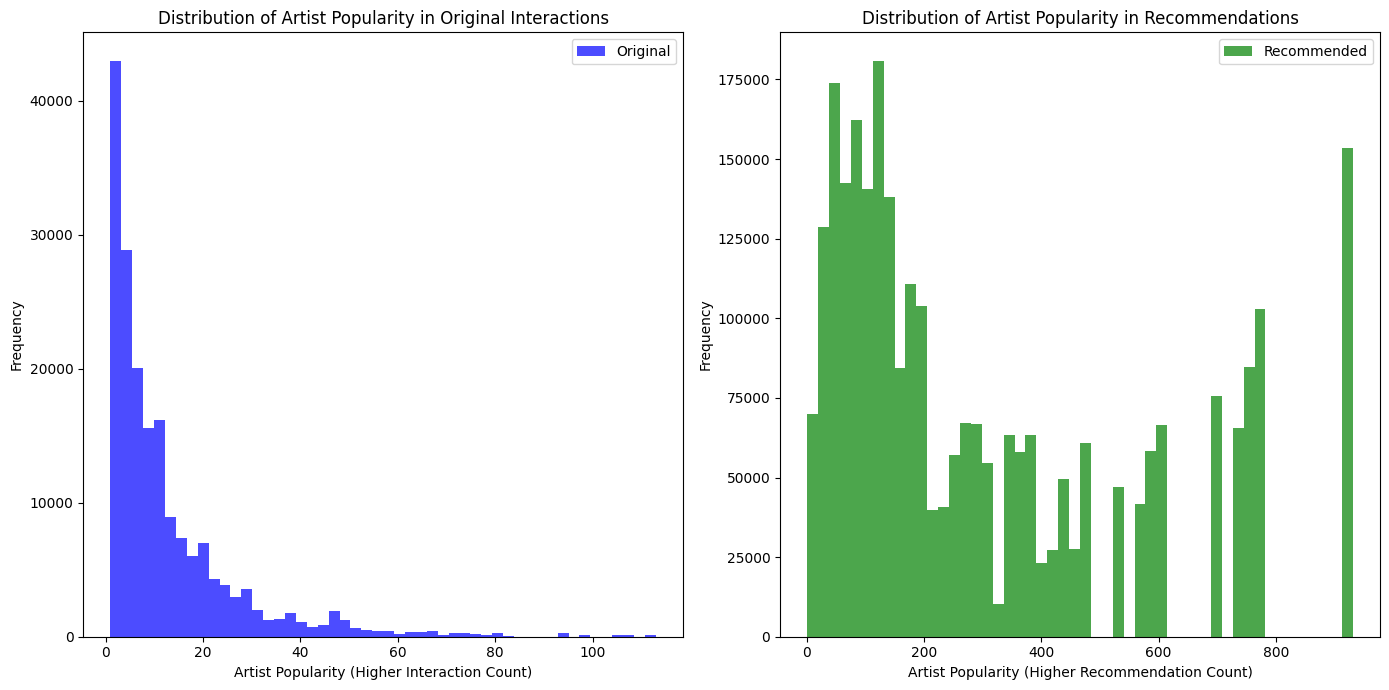

In [31]:
plt.figure(figsize=(14, 7))

# Histogram for original popularity
plt.subplot(1, 2, 1)
plt.hist(original_popularity, bins=50, alpha=0.7, color='blue', label='Original')
plt.title("Distribution of Artist Popularity in Original Interactions")
plt.xlabel("Artist Popularity (Higher Interaction Count)")
plt.ylabel("Frequency")
plt.legend()

# Histogram for recommended popularity
plt.subplot(1, 2, 2)
plt.hist(recommended_popularity, bins=50, alpha=0.7, color='green', label='Recommended')
plt.title("Distribution of Artist Popularity in Recommendations")
plt.xlabel("Artist Popularity (Higher Recommendation Count)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()
